In [1]:
import os
import pandas as pd
from PIL import Image
import requests
import torch
from transformers import AutoTokenizer, AutoModel, BlipProcessor, BlipForConditionalGeneration

In [2]:
df = pd.read_csv('../Datasets/44k/test.csv')

In [3]:

# Initialize the models for image captioning
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to("cuda")


d:\Anaconda\envs\pytorchenv\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [4]:

# Initialize the sentence transformer model
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/msmarco-distilbert-base-tas-b")
sentence_model = AutoModel.from_pretrained("sentence-transformers/msmarco-distilbert-base-tas-b")


In [5]:

# Function to encode texts into embeddings
def encode(texts):
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**encoded_input, return_dict=True)
    return model_output.last_hidden_state[:, 0]


In [6]:

def generate_captions(image_path, queries):
    raw_image = Image.open(image_path).convert('RGB')
    captions = []
    for text in queries:
        inputs = processor(raw_image, text, return_tensors="pt").to("cuda")
        out = model.generate(**inputs)
        caption = processor.decode(out[0], skip_special_tokens=True)
        
        # Extract the relevant part of the caption
        relevant_caption = caption.replace(text, "").strip()
        captions.append(relevant_caption)
    return captions

In [7]:

# List of queries for conditional image captioning
queries = ["Type of sleeves", "Color of Cloth", "Type of cloth", "Pattern of dress", "Neckline of dress", "Type of print", "Type of pattern",]

In [9]:
import pandas as pd
import os
from PIL import Image
import torch
from transformers import AutoTokenizer, AutoModel, BlipProcessor, BlipForConditionalGeneration

# Load the dataset
df = pd.read_csv('../Datasets/44k/test.csv')

# Initialize processor and model for caption generation
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to("cuda")

# Initialize sentence transformer model and tokenizer for similarity computation
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/msmarco-distilbert-base-tas-b")
sentence_model = AutoModel.from_pretrained("sentence-transformers/msmarco-distilbert-base-tas-b").to("cuda")

# CLS Pooling
def cls_pooling(model_output):
    return model_output.last_hidden_state[:, 0]

# Encode text
def encode(texts):
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt').to("cuda")
    with torch.no_grad():
        model_output = sentence_model(**encoded_input, return_dict=True)
    embeddings = cls_pooling(model_output)
    return embeddings

# Simulate finding matching images function
def find_matches(query, n=3):
    # This should be replaced with the actual implementation of match_finder.find_matches
    # For now, we return the first n images from the dataset for simplicity
    return df['image'].tolist()[:n]

# Generate captions for a given image
def generate_captions(image_path, queries):
    raw_image = Image.open(image_path).convert('RGB')
    captions = []
    for text in queries:
        inputs = processor(raw_image, text, return_tensors="pt").to("cuda")
        out = model.generate(**inputs)
        caption = processor.decode(out[0], skip_special_tokens=True)
        captions.append(caption)
    return captions

# Compute similarity scores
def compute_similarity_scores(query, docs):
    query_emb = encode([query])
    doc_emb = encode(docs)

    query_norm = torch.norm(query_emb, dim=1)
    doc_norm = torch.norm(doc_emb, dim=1)

    query_emb = query_emb / query_norm.unsqueeze(1)
    doc_emb = doc_emb / doc_norm.unsqueeze(1)

    scores = torch.mm(query_emb, doc_emb.transpose(0, 1))[0].cpu().tolist()
    return scores

# Define list of queries for generating captions
queries = ["Type of sleeves", "Color of Cloth", "Type of cloth", "Pattern of dress", "Neckline of dress", "Type of print", "Type of pattern"]

# Main loop to process each caption in the dataset
final_scores = []
for index, row in df.iterrows():
    prompt = row['caption']
    matches = find_matches(query=prompt, n=3)

    all_image_scores = []
    for match in matches:
        image_path = os.path.join('../Datasets/44k/Images', match)
        generated_captions = generate_captions(image_path, queries)

        # Compute similarity scores between the prompt and generated captions
        scores = compute_similarity_scores(prompt, generated_captions)
        average_score = sum(scores) / len(scores)
        all_image_scores.append(average_score)
    
    # Calculate final average score for the current caption
    final_average_score = sum(all_image_scores) / len(all_image_scores)
    final_scores.append(final_average_score)

# Print the final scores
print(final_scores)


d:\Anaconda\envs\pytorchenv\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[0.8473130691619147, 0.84467975014732, 0.8310922469411578, 0.8389140793255397, 0.8052231300444831, 0.8278020762261891, 0.7892348056747801, 0.8294008856727965, 0.8341429687681652, 0.8460697219485328, 0.8058039886610849, 0.8321895202000936, 0.7125974893569946, 0.7939089650199526, 0.7268430590629578, 0.7956952935173399, 0.8435896180924916, 0.7131485768726894, 0.7797444264094034, 0.8201234340667725, 0.8388615846633911, 0.8237311357543583, 0.8234659348215376, 0.8392404062407358, 0.7616869807243347, 0.8328882030078342, 0.8179376125335693, 0.7858933409055074, 0.7776136824062893, 0.8012143770853678, 0.747322054136367, 0.7797444264094034, 0.7797444264094034, 0.7936280511674427, 0.8452736877259754, 0.8381375869115194, 0.8420669294538952, 0.7398937429700578, 0.7125974893569946, 0.819287155355726, 0.8308461365245637, 0.8359805373918442, 0.8234659348215376, 0.8291540883836293, 0.7853504305794127, 0.7797444264094034, 0.8309664016678221, 0.8234659348215376, 0.8270512592224848, 0.8235326863470531, 0.8

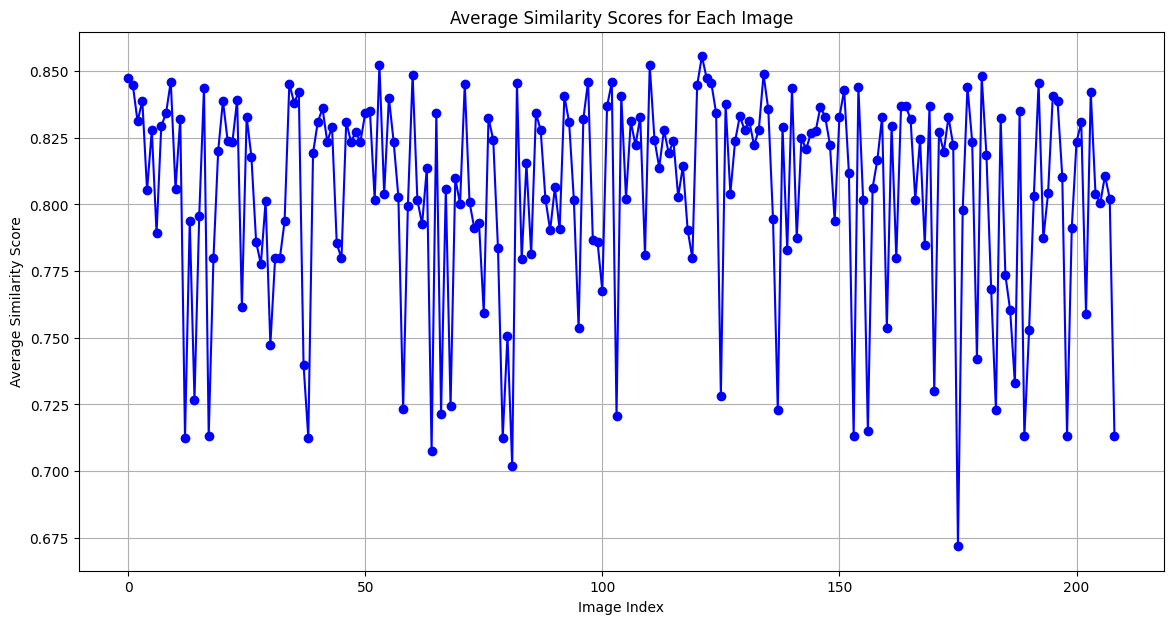

In [11]:
import matplotlib.pyplot as plt

# Plotting Line Plot
plt.figure(figsize=(14, 7))
plt.plot(final_scores, marker='o', linestyle='-', color='b')
plt.title('Average Similarity Scores for Each Image')
plt.xlabel('Image Index')
plt.ylabel('Average Similarity Score')
plt.grid(True)
plt.show()


In [12]:
final_scores

[0.8473130691619147,
 0.84467975014732,
 0.8310922469411578,
 0.8389140793255397,
 0.8052231300444831,
 0.8278020762261891,
 0.7892348056747801,
 0.8294008856727965,
 0.8341429687681652,
 0.8460697219485328,
 0.8058039886610849,
 0.8321895202000936,
 0.7125974893569946,
 0.7939089650199526,
 0.7268430590629578,
 0.7956952935173399,
 0.8435896180924916,
 0.7131485768726894,
 0.7797444264094034,
 0.8201234340667725,
 0.8388615846633911,
 0.8237311357543583,
 0.8234659348215376,
 0.8392404062407358,
 0.7616869807243347,
 0.8328882030078342,
 0.8179376125335693,
 0.7858933409055074,
 0.7776136824062893,
 0.8012143770853678,
 0.747322054136367,
 0.7797444264094034,
 0.7797444264094034,
 0.7936280511674427,
 0.8452736877259754,
 0.8381375869115194,
 0.8420669294538952,
 0.7398937429700578,
 0.7125974893569946,
 0.819287155355726,
 0.8308461365245637,
 0.8359805373918442,
 0.8234659348215376,
 0.8291540883836293,
 0.7853504305794127,
 0.7797444264094034,
 0.8309664016678221,
 0.82346593482153

In [13]:
len(final_scores)

209

In [16]:
final_final_average_score = sum([i for i in final_scores]) / len(final_scores)
final_final_average_score

0.8041769867063955